In [ ]:
# ! pip install pixellib

# Modul Import

In [ ]:
import os
import urllib
import cv2
import numpy as np
import pixellib
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

# Data 준비

(407, 626, 3)


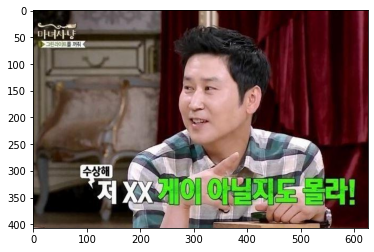

In [ ]:
img_path = '/content/drive/MyDrive/Data/001CV/ex10_human_seg/images/저XX.png'
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
model_file = '/content/drive/MyDrive/Data/001CV/ex10_human_seg/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# Segmentation 모델 생성

In [ ]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

# 모델에 이미지 입력

In [ ]:
segvalues, output = model.segmentAsPascalvoc(img_path)

## PASCAL VOC 데이터의 라벨 종류

In [ ]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

## 이미지 출력

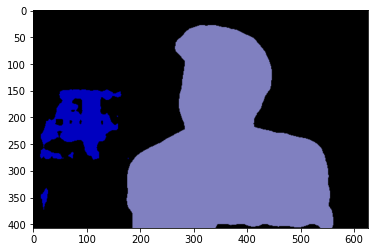

In [ ]:
plt.imshow(output)
plt.show()

## 분류된 클래스 확인하기

In [ ]:
segvalues

{'class_ids': array([ 0,  9, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

0, 9, 15 가 출력되었으므로 **'background', 'chair','person'** 이 분류되었다.

In [ ]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
chair
person


확인 결과 맞음

In [ ]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [ ]:
colormap[15]

array([192, 128, 128])

color map이 bgr순서이므로 rgb순으로 변경

In [ ]:
seg_color = (128,128,192)

## 마스크 생성

사람을 추출해낸 seg_color로만 이루어진 마스크를 만든다.

(407, 626)


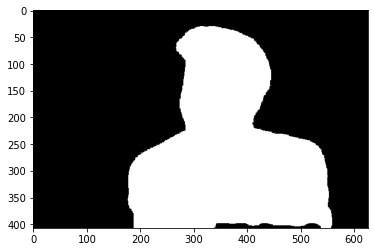

In [ ]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

원래 이미지와 겹쳐 분리가 얼마나 잘 되었는지 확인

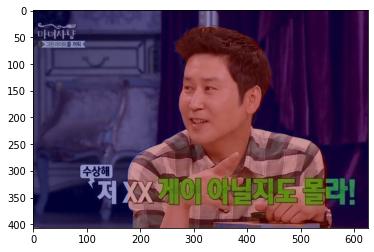

In [ ]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

# 배경 흐리게 만들기

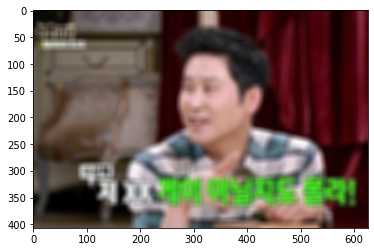

In [ ]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출

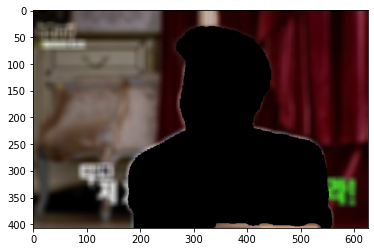

In [ ]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

bitwise_not 함수를 이용하면 이미지가 반전됨 

원래 마스크에서는 배경이 0, 사람이 255였으니 bitwise_not 연산을 하고 나면 배경은 255, 사람은 0이 되는 결과.

반전된 세그멘테이션 결과를 이용해서 이미지와 bitwise_and 연산을 수행하면 배경만 있는 영상을 얻을 수 있다. 

0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 되므로 사람이 사라지게 됨

# 원본과 배경을 합친다.

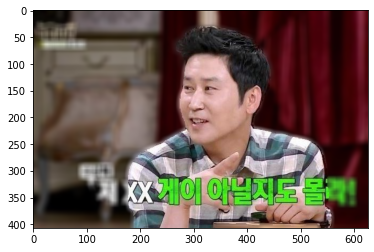

In [ ]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 루브릭

**Step 1. 인물모드 직접 해 보기**

**최소 3장 이상의 인물모드 사진**을 만들어 봅시다.

인물이 주인공이 아닌, 귀여운 고양이에 대한 아웃포커싱 사진도 만들어 볼 수 있을 것입니다. 시맨틱 세그멘테이션 스텝에서 힌트를 찾아봅시다.

배경을 blur하는 인물모드 사진이 아니라 **배경사진을 다른 이미지로 교체하는 크로마키 배경 합성을 시도**해 볼 수도 있을 것입니다.

**Step 2. 사진에서 문제점 찾기**

그러나 여러분들의 사진에는 무언가 문제점이 있을 것입니다.

어떤 문제가 있는지 찾아서 표시해 봅시다.

추가로 여러분이 만들어 낸 인물 모드 사진 중 하나에서도 이상한 위치를 찾아 아래 사진처럼 표시해 봅시다. 표시한 이미지들을 jupyter notebook에 포함하여 제출해 주세요.

**Step 3. 해결 방법을 제안해 보기**

아주 간단히 멋진 카메라 앱 서비스를 만들어 출시할 수 있을 것 같았지만, 지금 같은 완성도로는 어림도 없습니다. 소비자들의 눈높이는 그리 호락호락하지 않고, 엔지니어인 여러분들은 답을 찾아내야 합니다.

생각해 볼 만한 주제를 아래에 몇 가지 제시해 봅니다. 아래를 읽어본 후, 여러분이 만든 인물모드 사진의 문제점을 해결할 방안을 정리하여 제안해 주시기 바랍니다.
**단순히 'XXX 기술을 사용한다.' 정도의 선언적 솔루션이 아니라**, 여러분들이 선택한 기술이 DeepLab 모델의 Semantic Segmentation 이 만들어 낸 Mask 영역에 **어떻게 적용되어 문제점을 보완하게 되는지의 메커니즘이 포함된 솔루션**이어야 합니다

## Step 1. 인물모드 직접 해 보기

### 한 번에 처리하는  함수 만들기

In [ ]:
# 전제: 모델이 이미 불러져 있어야 함.
# model = semantic_segmentation()
# model.load_pascalvoc_model(model_file)
def seg_picture(imgpath):

    img_orig = cv2.imread(imgpath) # 이미지 불러오기. brg상태, 사람과 배경 합성할 때 사용

    segvalues, output = model.segmentAsPascalvoc(imgpath) # 모델에 이미지 입력
    
    # segvalues 분류된 클래스.
    # output 분류된 이미지.


    # 컬러맵 생성
    colormap = np.zeros((256, 3), dtype = int)
    ind = np.arange(256, dtype=int)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3

    colormap[:20] # 컬러맵 생성

    seg_color_BGR = colormap[15]
    seg_color = seg_color_BGR[::-1]

    # 사람을 분리하는 마스크 생성

    # output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
    seg_map = np.all(output==seg_color, axis=-1)

    #배경 블러처리, segmentaion된 부분을 확실히 구분하기 위해 값을 크게 주었다.
    img_orig_blur = cv2.blur(img_orig, (40,40))

    img_mask = seg_map.astype(np.uint8) * 255

    # 사람과 배경을 분리
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
    
    # 배경과 사람 합치기
    plt.figure(figsize=(10,10))
    img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()

In [ ]:
img1 ='/content/drive/MyDrive/Data/001CV/ex10_human_seg/images/image_test.jpg'
img2 = '/content/drive/MyDrive/Data/001CV/ex10_human_seg/images/self.jpg'
img3 = '/content/drive/MyDrive/Data/001CV/ex10_human_seg/images/es.JPG'

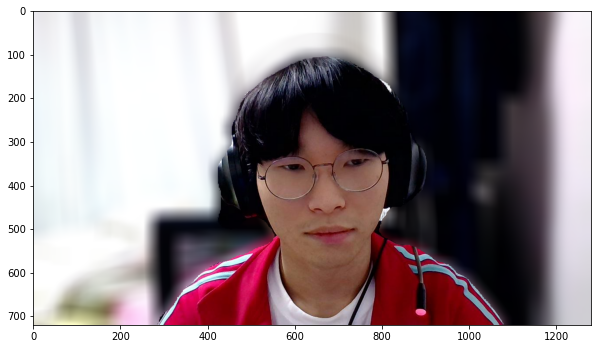

In [ ]:
seg_picture(img1)

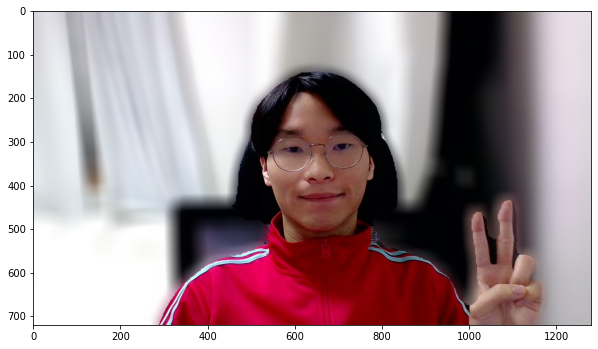

In [ ]:
seg_picture(img2)

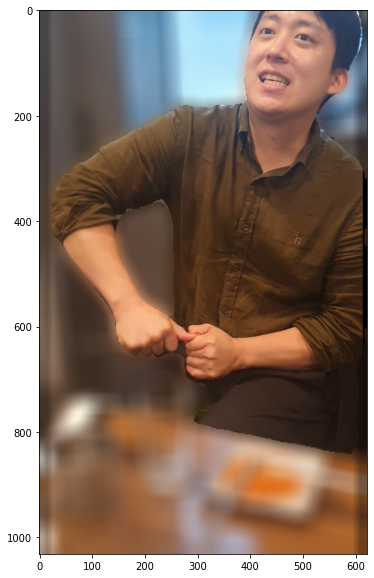

In [ ]:
seg_picture(img3)

## Step 2. 문제점 찾기

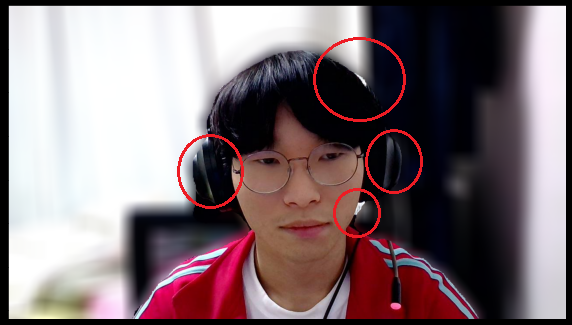

배경이 덜 분류된 부분이 약간 있고, 헤드셋을 내 머리로 인식함.

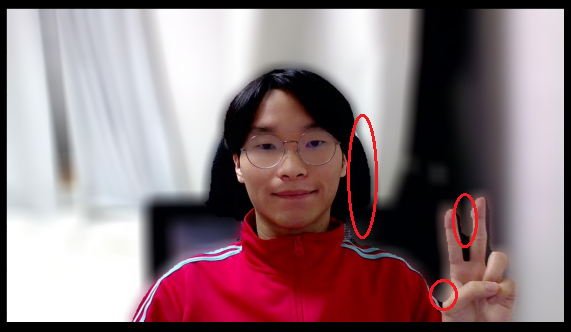

의자 머리받이 부분을 나로 분류했으며, 손가락과 손 일부를 분류하지 못했다.

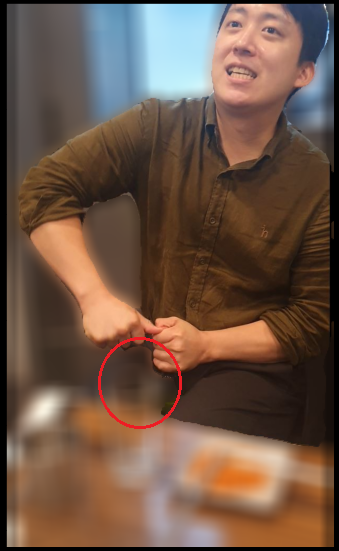

다리를 없애버렸다.

## Step 3. 해결 방법을 제안해 보기

< 문제 인식 >

DeepLab V3+ 에서 pre-trained 모델을 사용한 결과는 분명 크게는 물체를 잘 구분하지만 , 디테일하게 인식하지 못하였다.

예를 들자면 다리를 배경으로 인식 하거나, 의자의 목받이 부분을 사람으로 인식하는 문제들이 있었다.

나는 이 문제들이 발생한 이유가 모델이 이미지 안에 존재하는 객체들의 심도(depth)를 인식하지 못했기 때문이라 생각한다. 따라서 심도와 함께 객체들을 인식할 수 있다면 인간의 관점에서 image segmentation 결과가 조금 더 자연스럽게 보일 것이라 예상한다.

또한 특정한 기기가 촬영한 이미지가 아닌 일반적으로 사용할 수 있는 기기에서 촬영한 이미지를 디테일하게 잘 구분할 해야 하므로, 특정 기기가 필요한 기술은 제외해야 한다.



### Solution

https://arxiv.org/pdf/1910.01460

아카이브에서 한 논문을 찾았는데 RGB-D 이미지로 학습시킨 심도를 인식하는 모델을 통해 RGB 이미지에서 심도를 추출해 낸다는 내용인 듯 하다.

자세히 들여다 보지는 못했지만 3D Neighborhood Convolution 이란 것을 사용하여 depth map 을 만들어 낸다는 듯 하다.